# ResNet-based Fusion Model Testing

This notebook tests the trained ResNet-based CT-MRI fusion model with comprehensive evaluation metrics and visualizations.

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from typing import Tuple, Dict, Any
import sys

# Add path to utils for metrics
sys.path.append('..')
from utils.metrics import evaluate_fusion_comprehensive, get_metric_descriptions

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [10]:
# ResNet-based Fusion Network (same as training)
class ResNetFusionNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.fusion1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.fusion2 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.fusion3 = nn.Sequential(
            nn.Conv2d(2048, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def extract_features(self, x):
        x = x.repeat(1, 3, 1, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        f1 = self.layer1(x)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        return f1, f2, f3

    def forward(self, ct, mr):
        ct_f1, ct_f2, ct_f3 = self.extract_features(ct)
        mr_f1, mr_f2, mr_f3 = self.extract_features(mr)
        fused_f1 = self.fusion1(torch.cat([ct_f1, mr_f1], dim=1))
        fused_f2 = self.fusion2(torch.cat([ct_f2, mr_f2], dim=1))
        fused_f3 = self.fusion3(torch.cat([ct_f3, mr_f3], dim=1))
        x = self.up3(fused_f3)
        x = torch.cat([x, fused_f2], dim=1)
        x = self.up2(x)
        x = torch.cat([x, fused_f1], dim=1)
        x = self.up1(x)
        x = self.final(x)
        return x

In [11]:
# Dataset class for paired medical images (same as training)
class PairedMedicalFusionDataset(Dataset):
    """Paired dataset for registered CT & MRI images."""
    def __init__(self, root_ct: str, root_mri: str, resize: Tuple[int,int]=None,
                 file_exts=(".png",".jpg",".jpeg",".bmp",".tif",".tiff")):
        self.root_ct = root_ct
        self.root_mri = root_mri
        self.resize = resize

        def index_dir(root):
            paths = []
            for ext in file_exts:
                paths.extend(glob.glob(os.path.join(root, f"**/*{ext}"), recursive=True))
            base = {os.path.splitext(os.path.relpath(p, root))[0].replace('\\','/') : p for p in paths}
            return base

        base_ct = index_dir(root_ct)
        base_mr = index_dir(root_mri)
        self.keys = sorted(list(set(base_ct.keys()) & set(base_mr.keys())))
        if not self.keys:
            raise RuntimeError("No paired files found. Ensure matching filenames between CT and MRI.")
        self.base_ct = base_ct
        self.base_mr = base_mr

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx: int):
        key = self.keys[idx]
        p_ct = self.base_ct[key]
        p_mr = self.base_mr[key]

        ct = cv2.imread(p_ct, cv2.IMREAD_GRAYSCALE)
        mr = cv2.imread(p_mr, cv2.IMREAD_GRAYSCALE)
        if ct is None or mr is None:
            raise FileNotFoundError(p_ct if ct is None else p_mr)
        if self.resize is not None:
            H, W = self.resize
            ct = cv2.resize(ct, (W, H), interpolation=cv2.INTER_AREA)
            mr = cv2.resize(mr, (W, H), interpolation=cv2.INTER_AREA)

        ct = ct.astype(np.float32)
        mr = mr.astype(np.float32)
        if ct.max() > 1.0: ct /= 255.0
        if mr.max() > 1.0: mr /= 255.0

        ct_t = torch.from_numpy(ct)[None, ...]   # (1,H,W)
        mr_t = torch.from_numpy(mr)[None, ...]
        return ct_t, mr_t, key

In [12]:
# Configuration
ct_dir = '../Dataset/test/CT'
mri_dir = '../Dataset/test/MRI'
checkpoint_path = 'checkpoints/final/resnet_fusion/resnet_fusion_best.pt'
results_dir = 'test_results/resnet_fusion'
resize = (256, 256)
batch_size = 4

# Create results directory
os.makedirs(results_dir, exist_ok=True)

# Load trained model
print("Loading trained ResNet fusion model...")
model = ResNetFusionNet().to(device)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model'])
    print(f"✓ Loaded model from: {checkpoint_path}")
    print(f"  - Trained for {checkpoint['epoch']} epochs")
    print(f"  - Best validation loss: {checkpoint.get('best_val_loss', 'N/A'):.4f}")
else:
    print(f"✗ Checkpoint not found: {checkpoint_path}")
    print("Using untrained model for demonstration")

model.eval()

Loading trained ResNet fusion model...
✓ Loaded model from: checkpoints/final/resnet_fusion/resnet_fusion_best.pt
  - Trained for 24 epochs
  - Best validation loss: 0.5406


ResNetFusionNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), st

In [13]:
# Prepare test dataset
print("Preparing test dataset...")
test_dataset = PairedMedicalFusionDataset(ct_dir, mri_dir, resize=resize)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Test batches: {len(test_loader)}")

# Function to run inference on test set
def run_inference(model, test_loader, device):
    """Run inference on test set and collect results."""
    model.eval()
    results = []
    
    with torch.no_grad():
        for batch_idx, (ct_batch, mr_batch, keys) in enumerate(test_loader):
            ct_batch = ct_batch.to(device)
            mr_batch = mr_batch.to(device)
            
            # Forward pass
            fused_batch = model(ct_batch, mr_batch)
            
            # Convert to numpy for metrics calculation
            for i in range(len(keys)):
                ct_np = ct_batch[i].squeeze().cpu().numpy()
                mr_np = mr_batch[i].squeeze().cpu().numpy()
                fused_np = fused_batch[i].squeeze().cpu().numpy()
                
                results.append({
                    'key': keys[i],
                    'ct': ct_np,
                    'mr': mr_np,
                    'fused': fused_np
                })
            
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")
    
    return results

# Run inference
print("Running inference on test set...")
test_results = run_inference(model, test_loader, device)
print(f"✓ Inference completed. Processed {len(test_results)} image pairs.")

Preparing test dataset...
Test dataset size: 58
Test batches: 15
Running inference on test set...
Processed 10/15 batches
✓ Inference completed. Processed 58 image pairs.


In [14]:
# Calculate comprehensive metrics
print("Calculating evaluation metrics...")

all_metrics = []
for i, result in enumerate(test_results):
    metrics = evaluate_fusion_comprehensive(
        result['fused'], 
        result['ct'], 
        result['mr']
    )
    metrics['sample_id'] = i
    metrics['key'] = result['key']
    all_metrics.append(metrics)
    
    if (i + 1) % 50 == 0:
        print(f"Calculated metrics for {i + 1}/{len(test_results)} samples")

# Convert to DataFrame for analysis
metrics_df = pd.DataFrame(all_metrics)
print(f"✓ Metrics calculated for {len(all_metrics)} samples")

# Display metric descriptions
print("\n" + "="*60)
print("METRIC DESCRIPTIONS:")
print("="*60)
descriptions = get_metric_descriptions()
for metric, desc in descriptions.items():
    if metric in metrics_df.columns:
        print(f"{metric:15}: {desc}")
print()

# Summary statistics
print("SUMMARY STATISTICS:")
print("="*60)
summary_stats = metrics_df.describe()
key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev', 'Mean_Gradient']
summary_stats[key_metrics].round(4)

Calculating evaluation metrics...
Calculated metrics for 50/58 samples
✓ Metrics calculated for 58 samples

METRIC DESCRIPTIONS:
SSIM_Avg       : Average Structural Similarity Index (0-1, higher better)
PSNR_Avg       : Average Peak Signal-to-Noise Ratio (dB, higher better)
Edge_Preservation: Edge preservation correlation (0-1, higher better)
Entropy        : Information entropy (bits, higher better)
MI_Avg         : Average Mutual Information (bits, higher better)
Std_Dev        : Standard deviation (measure of contrast)
Mean_Gradient  : Average gradient magnitude (edge strength)

SUMMARY STATISTICS:


,SSIM_Avg,PSNR_Avg,Edge_Preservation,Entropy,MI_Avg,Std_Dev,Mean_Gradient
count,58.0000,58.0000,58.0000,58.0000,58.0000,58.0000,58.0000
mean,0.5858,17.4289,0.9114,5.8063,1.4311,0.2400,0.2507
std,0.0772,2.0878,0.0254,0.7675,0.2106,0.0497,0.0670
min,0.4767,14.1621,0.8345,3.2754,0.6450,0.1326,0.0545
25%,0.5241,15.9034,0.8960,5.4637,1.3200,0.2070,0.2028
50%,0.5824,16.8329,0.9083,5.8413,1.4522,0.2457,0.2622
75%,0.6164,18.5370,0.9304,6.3491,1.5393,0.2816,0.2983
max,0.7862,21.9300,0.9512,7.0964,1.8909,0.3120,0.4214


Generating visualizations...


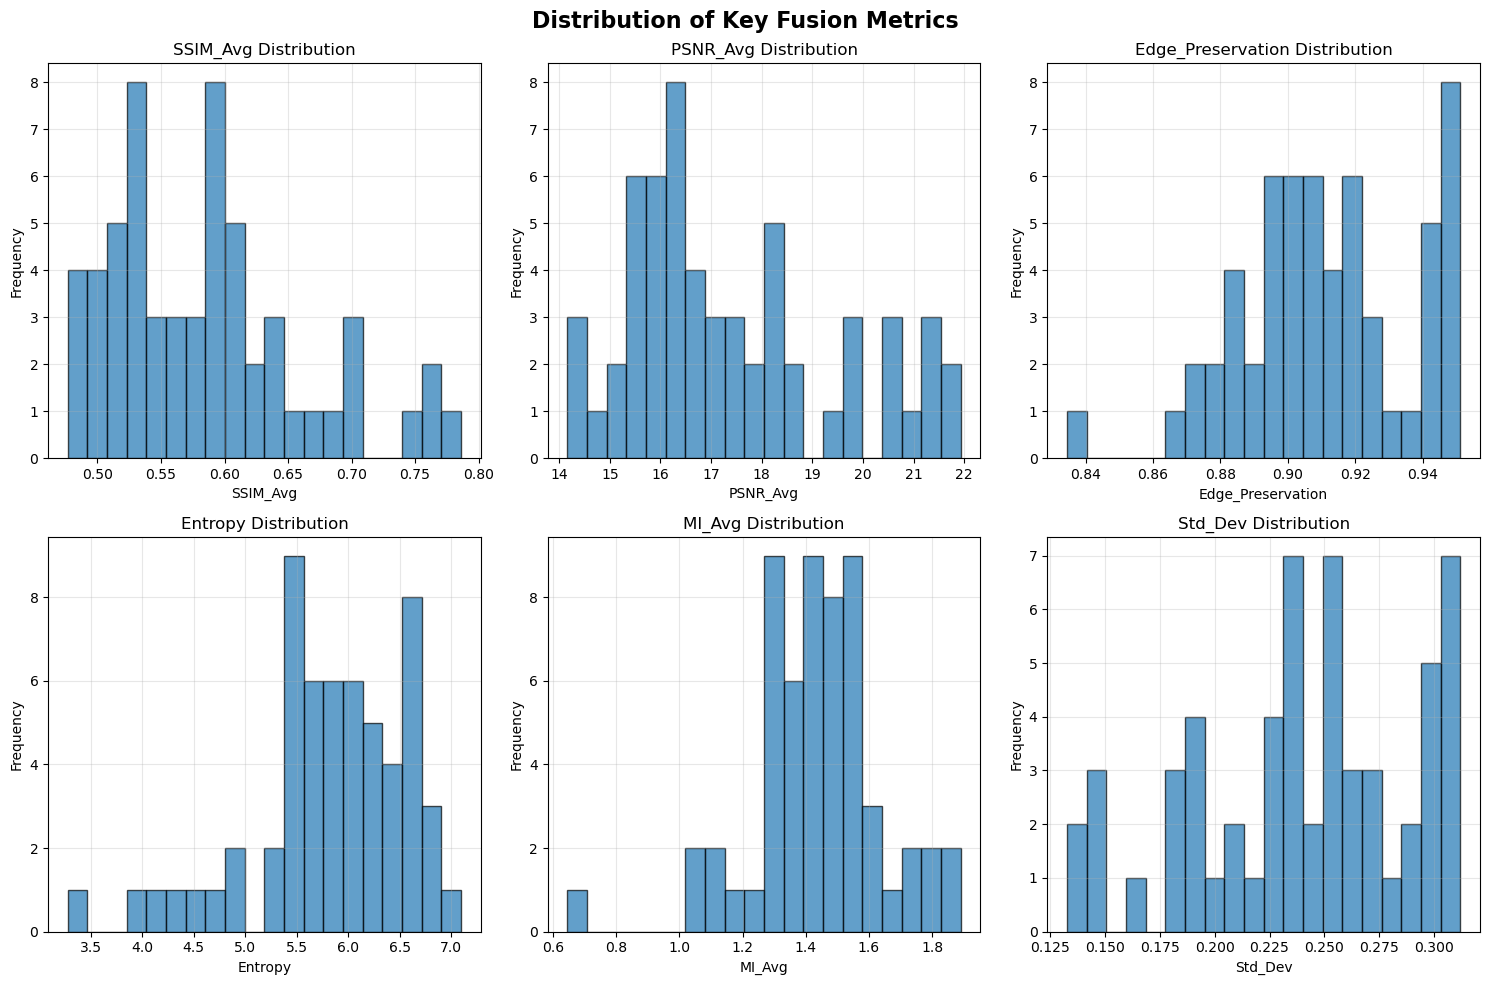

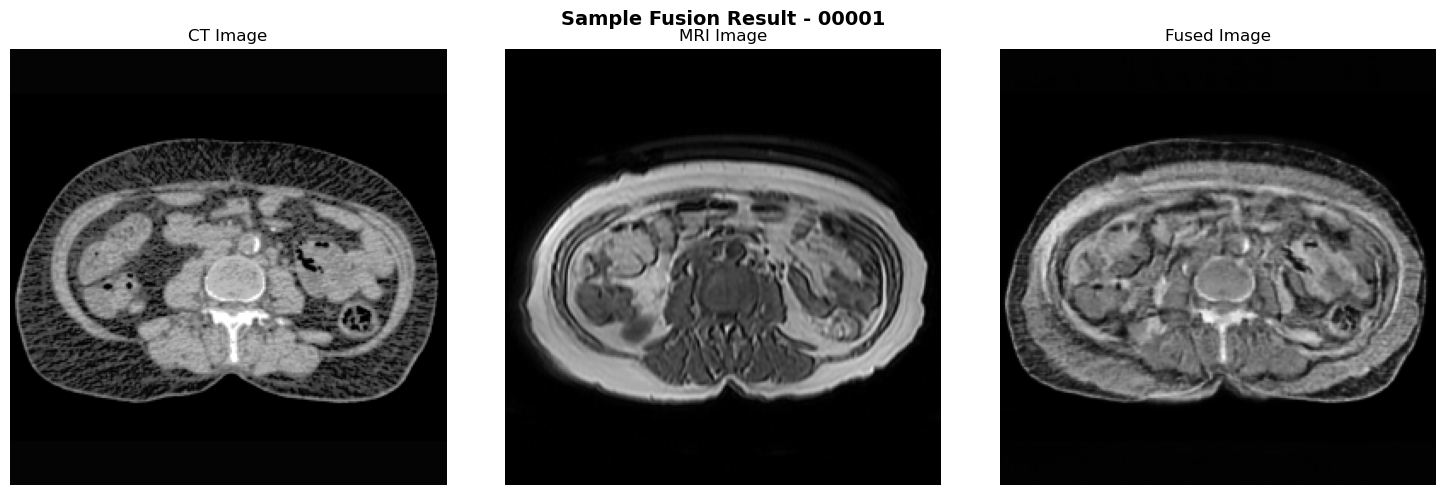


Metrics for sample 0 (00001):
----------------------------------------
SSIM_Avg       : 0.6583
PSNR_Avg       : 18.6363
Edge_Preservation: 0.8721
Entropy        : 5.4587
MI_Avg         : 1.7044
Std_Dev        : 0.2135


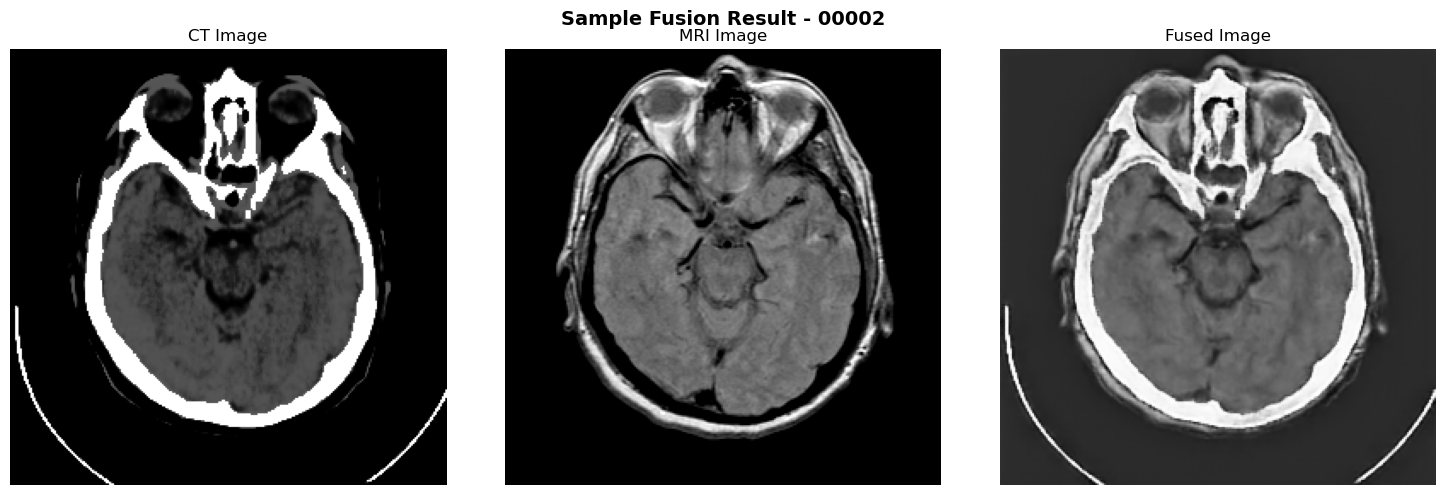


Metrics for sample 1 (00002):
----------------------------------------
SSIM_Avg       : 0.5154
PSNR_Avg       : 15.1933
Edge_Preservation: 0.8963
Entropy        : 6.1681
MI_Avg         : 1.1852
Std_Dev        : 0.2388


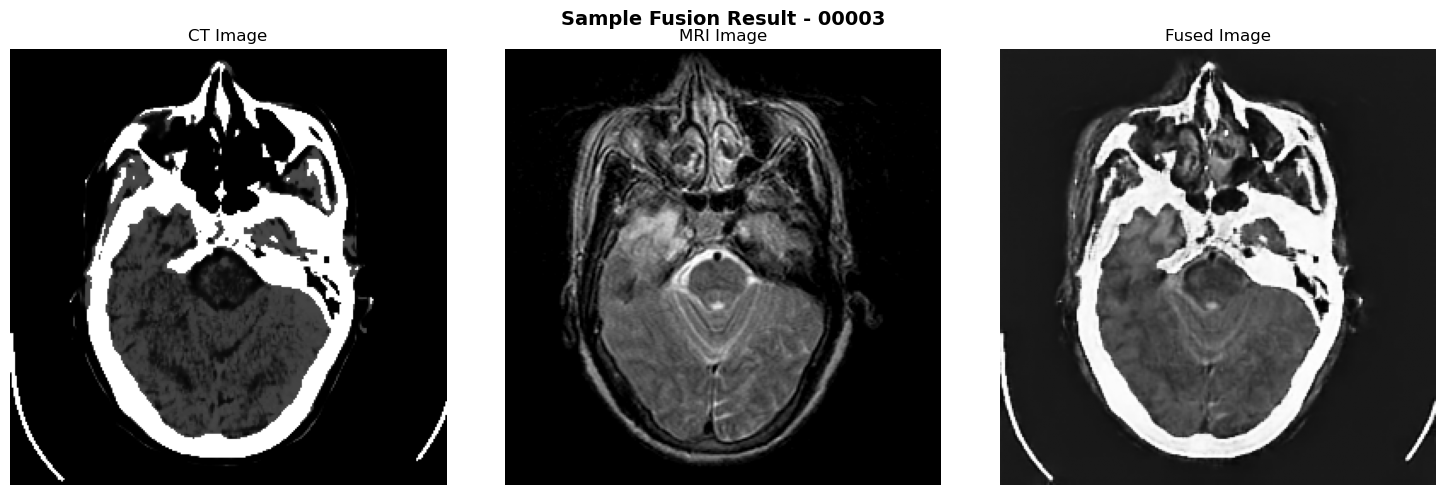


Metrics for sample 2 (00003):
----------------------------------------
SSIM_Avg       : 0.4917
PSNR_Avg       : 15.6373
Edge_Preservation: 0.9226
Entropy        : 5.8378
MI_Avg         : 1.1079
Std_Dev        : 0.2977


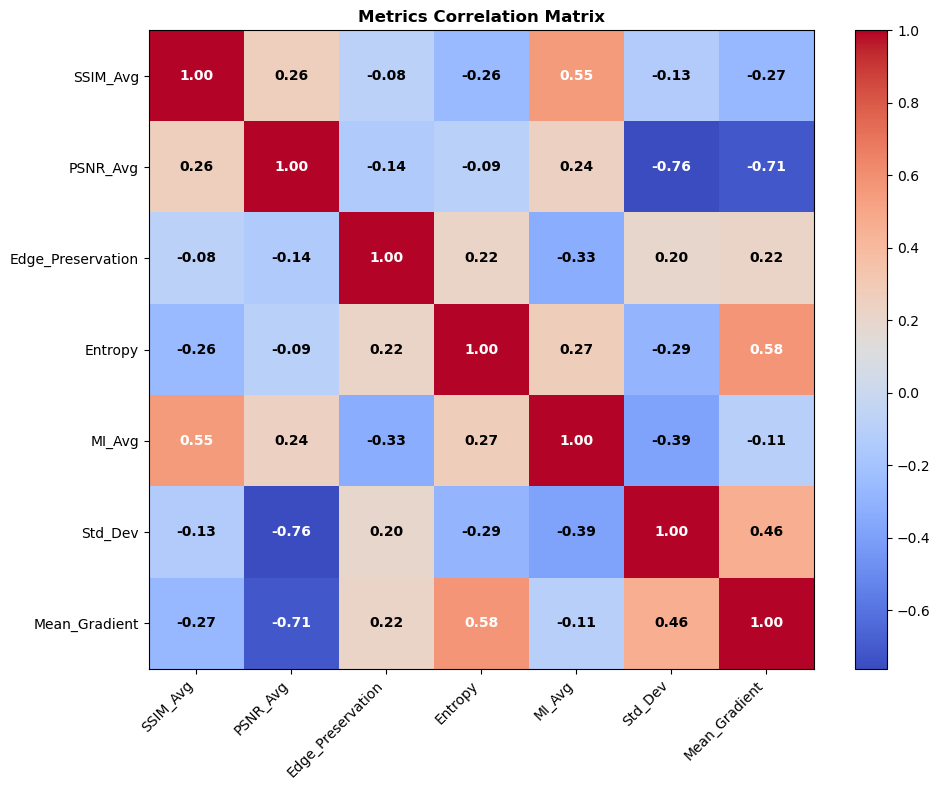


PERFORMANCE SUMMARY
Total samples tested: 58
Results saved to: test_results/resnet_fusion

Best performing sample (SSIM):
  Sample: 00014
  SSIM_Avg: 0.7862
  PSNR_Avg: 14.1621

Worst performing sample (SSIM):
  Sample: 00039
  SSIM_Avg: 0.4767
  PSNR_Avg: 15.8789

✓ Detailed results saved to test_results/resnet_fusion/detailed_metrics.csv
✓ All visualizations saved to results directory


In [15]:
# Visualization of Results
print("Generating visualizations...")

# 1. Metrics Distribution Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Fusion Metrics', fontsize=16, fontweight='bold')

key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev']
for i, metric in enumerate(key_metrics):
    ax = axes[i//3, i%3]
    ax.hist(metrics_df[metric], bins=20, alpha=0.7, edgecolor='black')
    ax.set_title(f'{metric} Distribution')
    ax.set_xlabel(metric)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'metrics_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# 2. Sample Fusion Results Visualization
def visualize_sample_fusion(sample_idx=0):
    """Visualize a sample fusion result."""
    if sample_idx >= len(test_results):
        print(f"Sample index {sample_idx} out of range. Max: {len(test_results)-1}")
        return
    
    sample = test_results[sample_idx]
    metrics = all_metrics[sample_idx]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Sample Fusion Result - {sample["key"]}', fontsize=14, fontweight='bold')
    
    # CT image
    axes[0].imshow(sample['ct'], cmap='gray')
    axes[0].set_title('CT Image')
    axes[0].axis('off')
    
    # MRI image
    axes[1].imshow(sample['mr'], cmap='gray')
    axes[1].set_title('MRI Image')
    axes[1].axis('off')
    
    # Fused image
    axes[2].imshow(sample['fused'], cmap='gray')
    axes[2].set_title('Fused Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'sample_fusion_{sample_idx}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print metrics for this sample
    print(f"\nMetrics for sample {sample_idx} ({sample['key']}):")
    print("-" * 40)
    for metric in key_metrics:
        if metric in metrics:
            print(f"{metric:15}: {metrics[metric]:.4f}")

# Visualize first few samples
for i in range(min(3, len(test_results))):
    visualize_sample_fusion(i)

# 3. Metrics Correlation Heatmap
correlation_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev', 'Mean_Gradient']
corr_matrix = metrics_df[correlation_metrics].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_metrics)), correlation_metrics, rotation=45, ha='right')
plt.yticks(range(len(correlation_metrics)), correlation_metrics)
plt.title('Metrics Correlation Matrix', fontweight='bold')

# Add correlation values
for i in range(len(correlation_metrics)):
    for j in range(len(correlation_metrics)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center', 
                color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black',
                fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'metrics_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

# 4. Performance Summary
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(f"Total samples tested: {len(test_results)}")
print(f"Results saved to: {results_dir}")
print()

# Best and worst performing samples
best_ssim_idx = metrics_df['SSIM_Avg'].idxmax()
worst_ssim_idx = metrics_df['SSIM_Avg'].idxmin()

print("Best performing sample (SSIM):")
print(f"  Sample: {metrics_df.loc[best_ssim_idx, 'key']}")
print(f"  SSIM_Avg: {metrics_df.loc[best_ssim_idx, 'SSIM_Avg']:.4f}")
print(f"  PSNR_Avg: {metrics_df.loc[best_ssim_idx, 'PSNR_Avg']:.4f}")
print()

print("Worst performing sample (SSIM):")
print(f"  Sample: {metrics_df.loc[worst_ssim_idx, 'key']}")
print(f"  SSIM_Avg: {metrics_df.loc[worst_ssim_idx, 'SSIM_Avg']:.4f}")
print(f"  PSNR_Avg: {metrics_df.loc[worst_ssim_idx, 'PSNR_Avg']:.4f}")

# Save detailed results
metrics_df.to_csv(os.path.join(results_dir, 'detailed_metrics.csv'), index=False)
print(f"\n✓ Detailed results saved to {results_dir}/detailed_metrics.csv")
print("✓ All visualizations saved to results directory")

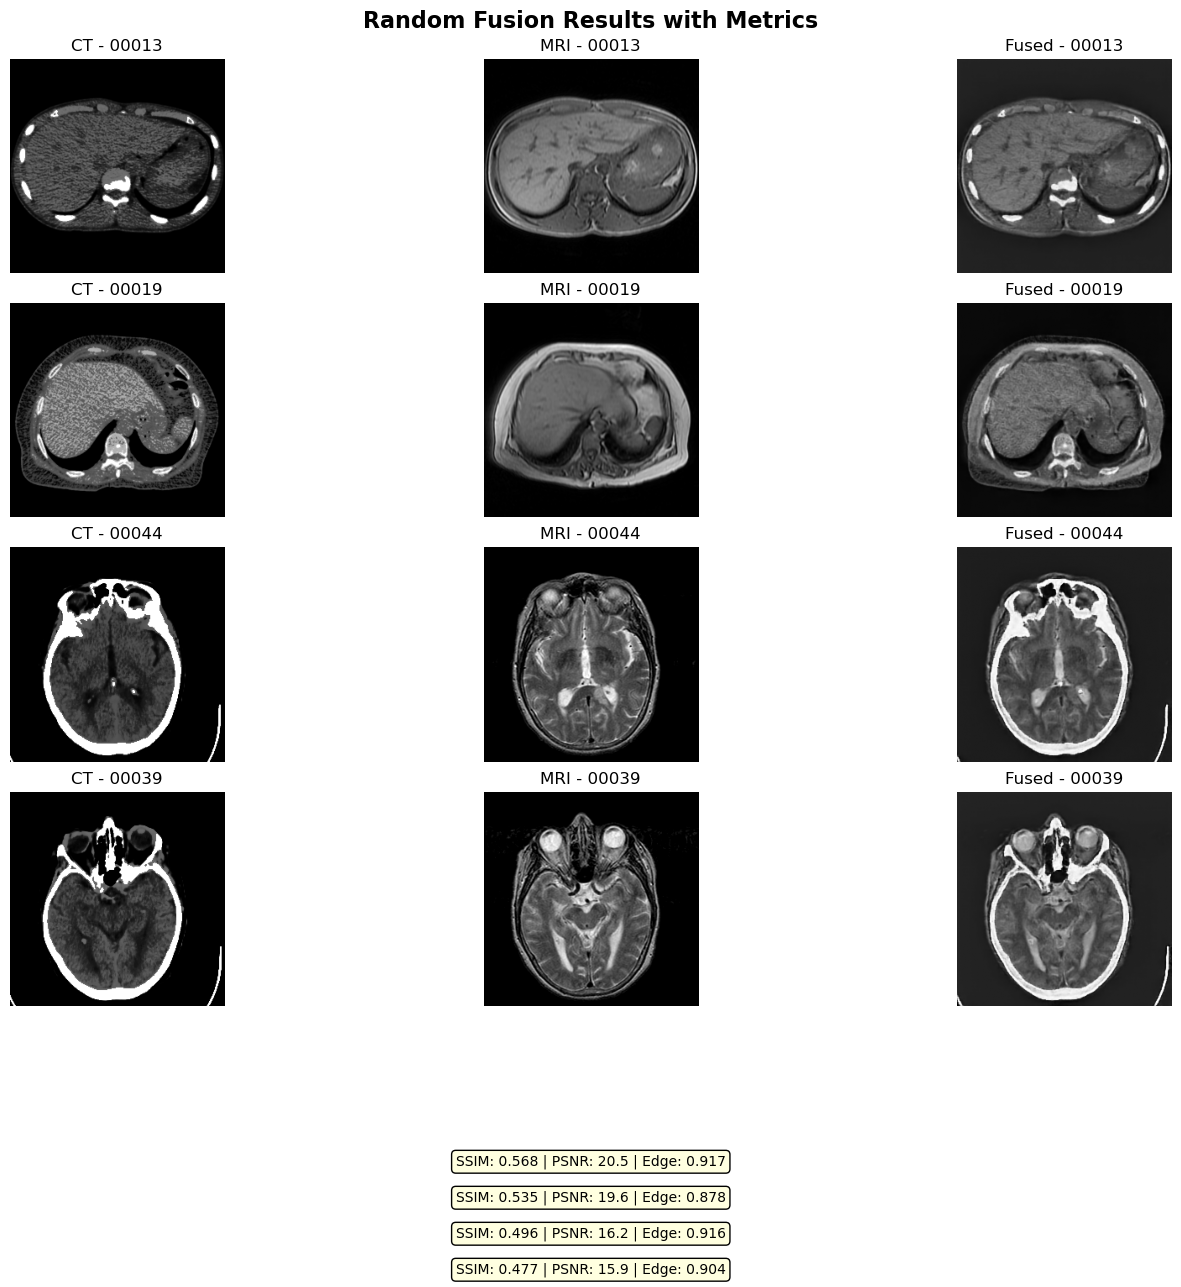


Detailed metrics for 4 random samples:

Sample 1: 00013
----------------------------------------
  SSIM_Avg       : 0.5677
  PSNR_Avg       : 20.5170
  Edge_Preservation: 0.9172
  Entropy        : 6.0512
  MI_Avg         : 1.5398

Sample 2: 00019
----------------------------------------
  SSIM_Avg       : 0.5346
  PSNR_Avg       : 19.6208
  Edge_Preservation: 0.8777
  Entropy        : 6.0732
  MI_Avg         : 1.5130

Sample 3: 00044
----------------------------------------
  SSIM_Avg       : 0.4963
  PSNR_Avg       : 16.1970
  Edge_Preservation: 0.9162
  Entropy        : 5.8203
  MI_Avg         : 1.3324

Sample 4: 00039
----------------------------------------
  SSIM_Avg       : 0.4767
  PSNR_Avg       : 15.8789
  Edge_Preservation: 0.9040
  Entropy        : 5.9879
  MI_Avg         : 1.2697


In [16]:
# 2. Random Fusion Results with Metrics
def display_random_fusion_results(test_results, all_metrics, num_samples=4, figsize=(16, 12)):
    """Display random fusion results with their evaluation metrics."""
    if len(test_results) == 0:
        print("No results available!")
        return

    # Select random indices
    random_indices = np.random.choice(len(test_results), min(num_samples, len(test_results)), replace=False)

    # Calculate grid dimensions
    cols = 3  # CT, MRI, Fused
    rows = len(random_indices)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Random Fusion Results with Metrics', fontsize=16, fontweight='bold')

    for row_idx, idx in enumerate(random_indices):
        sample = test_results[idx]
        metrics = all_metrics[idx]

        # CT Image
        axes[row_idx, 0].imshow(sample['ct'], cmap='gray')
        axes[row_idx, 0].set_title(f'CT - {sample["key"]}')
        axes[row_idx, 0].axis('off')

        # MRI Image
        axes[row_idx, 1].imshow(sample['mr'], cmap='gray')
        axes[row_idx, 1].set_title(f'MRI - {sample["key"]}')
        axes[row_idx, 1].axis('off')

        # Fused Image
        axes[row_idx, 2].imshow(sample['fused'], cmap='gray')
        axes[row_idx, 2].set_title(f'Fused - {sample["key"]}')
        axes[row_idx, 2].axis('off')

        # Add metrics text below each row
        metrics_text = f"SSIM: {metrics.get('SSIM_Avg', 0):.3f} | PSNR: {metrics.get('PSNR_Avg', 0):.1f} | Edge: {metrics.get('Edge_Preservation', 0):.3f}"

        # Add text below the subplot
        fig.text(0.5, 0.02 - (row_idx * 0.03), metrics_text,
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for metrics text
    plt.savefig(os.path.join(results_dir, 'random_fusion_results.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed metrics for random samples
    print(f"\nDetailed metrics for {len(random_indices)} random samples:")
    print("=" * 80)
    for i, idx in enumerate(random_indices):
        sample = test_results[idx]
        metrics = all_metrics[idx]
        print(f"\nSample {i+1}: {sample['key']}")
        print("-" * 40)
        key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg']
        for metric in key_metrics:
            if metric in metrics:
                print(f"  {metric:15}: {metrics[metric]:.4f}")

# Display random fusion results
display_random_fusion_results(test_results, all_metrics, num_samples=4)